# COVID-19 Drug Design using Generative RNN-LSTM

By Ho Jia Min

![coronavirus-structure.jpg](images/coronavirus-structure.jpg)

# 1. Introduction - Overview of problem and approach



COVID-19 is an infectious disease caused by a newly discovered strain of coronavirus (SARS-CoV-2), a type of virus known to cause respiratory infections in humans. This new strain was unknown before December 2019, when an outbreak of a pneumonia of unidentified cause emerged in Wuhan, China. The first case of COVID-19 in Malaysia was detected on 24 January 2020. 

Basic Local Alignment Search Tool (BLAST) results show close homology to the bat Coronavirus. A crystal structure of the main protease of the virus was obtained by Liu et al., found at https://www.rcsb.org/structure/6LU7

Since the outbreak, researchers have been collaborating and working closely to stop the spread of the disease and to propose possible treatment plans. New advances in machine intelligence have introduced algorithms that can learn important patterns from vast amounts of data, approaching expert-level of ability in some tasks. This means that anyone with these models can contribute to the global research effort. 

My project uses many ideas and implementations developed by others, and bring them together towards a common task. 

The aim of this project is to find drug candidates (ligand) with a high binding affinity with the COVID-19 main protease using deep learning.

1. Outline of the problem and introduction

2. Dataset preparation

3. Train LSTM-based RNN model

4. Generate SMILES strings

5. Use transfer learning to fine-tune model, generating molecules that are structurally similar to potential protease inhibitors of COVID-19

6. Use PyRx to get binding scores of molecules with SARS-CoV-2 main protease

7. Highest scoring candidates are reported



## References

Generative Recurrent Network for De Novo Drug Design https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5836943/ https://github.com/topazape/LSTM_Chem

Binding site analysis of potential protease inhibitors of COVID-19 using AutoDock https://link.springer.com/article/10.1007/s13337-020-00585-z

PubChem data related to COVID-19 https://pubchemdocs.ncbi.nlm.nih.gov/covid-19

Refer here for COVID-19 drugs in clinical trials https://pubchem.ncbi.nlm.nih.gov/#tab=compound&query=covid-19%20clinicaltrials


## Related Work

https://github.com/topazape/LSTM_Chem

https://github.com/forkwell-io/fch-drug-discovery

https://github.com/mattroconnor/deep_learning_coronavirus_cure

https://github.com/tmacdou4/2019-nCov


# Inhibitor TARGET: SARS-CoV-2 Main Protease

<img src='images/protease-inhibitor.png'/>

https://www.sciencedirect.com/science/article/pii/S2090123220300540

## Requirements

This model is built using Python 3.7, and utilizes the following packages;

- numpy
- pandas
- tensorflow
- tqdm
- Bunch
- matplotlib 
- RDKit 
- scikit-learn

RDKit is a collection of cheminformatics and machine-learning software.

RDKit and matplotlib are used for SMILES cleanup, validation, and visualization of molecules and their properties.

Scikit-learn is used for PCA.

In [ ]:
# conda install -c conda-forge rdkit
# conda install -c conda-forge bunch
# conda install -c conda-forge matplotlib
# conda install -c anaconda pandas
# conda install -c anaconda scikit-learn
# pip install tensorflow
# pip install keras

## Dataset Description

#### ZINC Database
https://zinc.docking.org \
https://github.com/molecularsets/moses

The set is based on the ZINC Clean Leads collection. It contains 4,591,276 molecules in total, filtered by molecular weight in the range from 250 to 350 Daltons, a number of rotatable bonds not greater than 7, and XlogP less than or equal to 3.5. Molecules containing charged atoms or atoms besides C, N, S, O, F, Cl, Br, H or cycles longer than 8 atoms have been removed. The molecules were filtered via medicinal chemistry filters (MCFs) and PAINS filters. The dataset contains 1,936,962 molecular structures. 

#### ChEMBL
https://www.ebi.ac.uk/chembl/ \
https://github.com/topazape/LSTM_Chem/blob/master/datasets/dataset.smi

ChEMBL is a manually curated database of bioactive molecules with drug-like properties. It brings together chemical, bioactivity and genomic data to aid the translation of genomic information into effective new drugs.

# 2. Dataset Preparation


Combine datasets from two sources: i) ZINC database and ii) ChEMBL. Together these two data sets represent about 2.5 million smiles.

In [2]:
import pandas as pd

In [2]:
# Load ZINC data

moses_smiles = pd.read_csv('./datasets/moses_dataset_v1.txt',sep=',')
print(moses_smiles.shape)
moses_smiles = moses_smiles[moses_smiles['SMILES'].notnull()]
print(moses_smiles.shape)
moses_smiles['smiles'] = moses_smiles["SMILES"]
moses_smiles['length'] = moses_smiles["smiles"].str.len()
moses_smiles.head()

(1936962, 2)
(1936962, 2)


,SMILES,SPLIT,smiles,length
0,CCCS(=O)c1ccc2[nH]c(=NC(=O)OC)[nH]c2c1,train,CCCS(=O)c1ccc2[nH]c(=NC(=O)OC)[nH]c2c1,38
1,CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1ccnc1,train,CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1ccnc1,36
2,CC1C2CCC(C2)C1CN(CCO)C(=O)c1ccc(Cl)cc1,test,CC1C2CCC(C2)C1CN(CCO)C(=O)c1ccc(Cl)cc1,38
3,Cc1c(Cl)cccc1Nc1ncccc1C(=O)OCC(O)CO,train,Cc1c(Cl)cccc1Nc1ncccc1C(=O)OCC(O)CO,35
4,Cn1cnc2c1c(=O)n(CC(O)CO)c(=O)n2C,train,Cn1cnc2c1c(=O)n(CC(O)CO)c(=O)n2C,32


In [3]:
# Load ChEMBL data

chembl_smiles = pd.read_csv('./datasets/chembl_dataset.txt', names=["smiles"])
chembl_smiles['length'] = chembl_smiles["smiles"].str.len() 
print(chembl_smiles.shape)
chembl_smiles.head()

(556134, 2)


,smiles,length
0,C1CCCCCNc2cc[n+](Cc3cccc(c3)c4cccc(C[n+]5ccc(N...,74
1,Br\C=C\1/CCC(C(=O)O1)c2cccc3ccccc23,35
2,I\C=C\1/CCC(C(=O)O1)c2cccc3ccccc23,34
3,O=C1O\C(=C\C#C)\CCC1c2cccc3ccccc23,34
4,I\C=C/1\CCC(C(=O)O1)c2cccc3ccccc23,34


In [4]:
# Drop duplicates and append both dataset

moses_smiles = moses_smiles['smiles']
print(moses_smiles.shape)
moses_smiles = moses_smiles.drop_duplicates()
print(moses_smiles.shape)

(1936962,)
(1936962,)


In [5]:
chembl_smiles = chembl_smiles['smiles']
print(chembl_smiles.shape)
chembl_smiles = chembl_smiles.drop_duplicates()
print(chembl_smiles.shape)

(556134,)
(556134,)


In [10]:
smiles = moses_smiles.append(chembl_smiles)
print(smiles.shape)
smiles = smiles.drop_duplicates()
print(smiles.shape)

(2493096,)
(2492860,)


In [11]:
# Total SMILES ~2.5 million
# Included this step to randomly sample 250000 smiles for model testing (run it in cloud GPU later for whole dataset)
smiles = smiles.sample(250000)

In [12]:
# save to csv
smiles.to_csv(r'./datasets/all_smiles.txt', header=None, index=None, sep='\t', mode='a')

In [13]:
all_smiles_test = pd.read_csv('./datasets/all_smiles.txt',sep='\t', header=None)
print(all_smiles_test.shape)
all_smiles_test.head()

(250000, 1)


,0
0,CCCCN(CC)C(=O)c1n[nH]c(=O)c2ccccc12
1,NC[C@@H]1C[C@@]1(C(=O)N(CC#C)CC#C)c2ccc3OCCOc3c2
2,NC(=O)c1nn(CC(=O)N2[C@@H]3C[C@@H]3C[C@H]2C(=O)...
3,CC(=O)c1c(C)[nH]c(C(=O)Nc2ccncc2)c1C
4,COc1ccc(C(=O)CCCC(=O)N(C)C)cc1F


### Potential COVID-19 protease inhibitors for model fine-tuning

According to this paper - Binding site analysis of potential protease inhibitors of COVID-19 using AutoDock https://link.springer.com/article/10.1007/s13337-020-00585-z

SMILES obtained from https://pubchem.ncbi.nlm.nih.gov/

1. Remdesivir- CCC(CC)COC(=O)C(C)NP(=O)(OCC1C(C(C(O1)(C#N)C2=CC=C3N2N=CN=C3N)O)O)OC4=CC=CC=C4

2. Nelfinavir- CC1=C(C=CC=C1O)C(=O)NC(CSC2=CC=CC=C2)C(CN3CC4CCCCC4CC3C(=O)NC(C)(C)C)O 

3. Lopinavir- CC1=C(C(=CC=C1)C)OCC(=O)NC(CC2=CC=CC=C2)C(CC(CC3=CC=CC=C3)NC(=O)C(C(C)C)N4CCCNC4=O)O

4. Ritonavir- CC(C)C1=NC(=CS1)CN(C)C(=O)NC(C(C)C)C(=O)NC(CC2=CC=CC=C2)CC(C(CC3=CC=CC=C3)NC(=O)OCC4=CN=CS4)O

Other protease inhibitors as potential treatments 

5. Darunavir- CC(C)CN(CC(C(CC1=CC=CC=C1)NC(=O)OC2COC3C2CCO3)O)S(=O)(=O)C4=CC=C(C=C4)N

6. Atazanavir- CC(C)(C)C(C(=O)NC(CC1=CC=CC=C1)C(CN(CC2=CC=C(C=C2)C3=CC=CC=N3)NC(=O)C(C(C)(C)C)NC(=O)OC)O)NC(=O)OC

These protease inhibitors SMILES are added into datasets/protease_inhibitors_for_fine-tune.txt

In [14]:
protease_smiles_test = pd.read_csv('./datasets/protease_inhibitors_for_fine-tune.txt',sep='\t', header=None)
print(protease_smiles_test.shape)
protease_smiles_test

(6, 1)


,0
0,CCC(CC)COC(=O)C(C)NP(=O)(OCC1C(C(C(O1)(C#N)C2=...
1,CC1=C(C=CC=C1O)C(=O)NC(CSC2=CC=CC=C2)C(CN3CC4C...
2,CC1=C(C(=CC=C1)C)OCC(=O)NC(CC2=CC=CC=C2)C(CC(C...
3,CC(C)C1=NC(=CS1)CN(C)C(=O)NC(C(C)C)C(=O)NC(CC2...
4,CC(C)CN(CC(C(CC1=CC=CC=C1)NC(=O)OC2COC3C2CCO3)...
5,CC(C)(C)C(C(=O)NC(CC1=CC=CC=C1)C(CN(CC2=CC=C(C...


## Pre-processing

Preprocess dataset to remove duplicates, salts, stereochemical information, nucleic acids and long peptides. https://github.com/topazape/LSTM_Chem

In anaconda prompt, cd to the file and run **python cleanup_smiles.py datasets/all_smiles.txt datasets/all_smiles_clean.txt**

After cleaning the smiles using the cleanup_smiles.py script and only retaining smiles between 34 to 128 characters in length, './datasets/all_smiles_clean.txt' contains the final list of 180793 smiles on which the model was trained.

In [15]:
all_smiles_clean = pd.read_csv('./datasets/all_smiles_clean.txt',sep='\t', header=None)
print(all_smiles_clean.shape)
all_smiles_clean.head()

(180793, 1)


,0
0,NC(=O)c1cnn2cc(-c3cccnc3)cc2c1NC1CCOCC1
1,COC(=O)C(NC1CCc2c(F)cccc21)c1cccc(C#N)c1
2,CC1CCCC(CNC(=O)CNC(=O)c2ccc(F)c(F)c2)C1
3,CC1CN(CC2CCN(C(=O)C(C)(C)C)CC2)CC(C)O1
4,NC(=O)C1Cc2ccccc2N1C(=O)c1ccc2ccccc2n1


# 3. Train LSTM-based RNN model to generate SMILES

<img src='images/figure1.png' style='width:500px;height:250px'/>

The structure of this model consists of **two LSTM layers**, each with a **hidden state vector of size 256**, regularized with **dropout**. These two layers are followed by a **dense output layer** and a neuron unit with a **softmax activation function**. The input to the LSTM is a one-hot-encoded sequence of a molecules's SMILES string.

<img src='images/figure2.png' style='width:500px;height:500px'/>
<img src='images/figure3.png' style='width:500px;height:500px'/>

Images obtained from this paper - Generative Recurrent Networks for De Novo Drug Design https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5836943/

### Extra Information


**Recurrent Neural Network (RNN)** 

Generalization of feedforward neural network that has an internal memory. RNN is recurrent in nature as it performs the same function for every input of data while the output of the current input depends on the past one computation. After producing the output, it is copied and sent back into the recurrent network. For making a decision, it considers the current input and the output that it has learned from the previous input.
Unlike feedforward neural networks, RNNs can use their internal state (memory) to process sequences of inputs. This makes them applicable to tasks such as unsegmented, connected handwriting recognition or speech recognition. In other neural networks, all the inputs are independent of each other. But in RNN, all the inputs are related to each other.
https://towardsdatascience.com/understanding-rnn-and-lstm-f7cdf6dfc14e

**Long Short-Term Memory (LSTM)** 

Modified version of recurrent neural networks, which makes it easier to remember past data in memory. The vanishing gradient problem of RNN is resolved here. LSTM is well-suited to classify, process and predict time series given time lags of unknown duration. It trains the model by using back-propagation. In an LSTM network, three gates are present: input gate, forget gate and output gate. \
https://colah.github.io/posts/2015-08-Understanding-LSTMs/

![lstm.jpg](images/lstm.jpg)

In [16]:
from copy import copy
from lstm_chem.utils.config import process_config
from lstm_chem.utils.dirs import create_dirs
from lstm_chem.data_loader import DataLoader
from lstm_chem.model import LSTMChem
from lstm_chem.trainer import LSTMChemTrainer

CONFIG_FILE = 'experiments/base_experiment/LSTM_Chem/config.json'


def main():
    config = process_config(CONFIG_FILE)

    # create the experiments dirs
    create_dirs(
        [config.exp_dir, config.tensorboard_log_dir, config.checkpoint_dir])

    print('Create the data generator.')
    train_dl = DataLoader(config, data_type='train')
    valid_dl = copy(train_dl)
    valid_dl.data_type = 'valid'

    print('Create the model.')
    modeler = LSTMChem(config, session='train')

    print('Create the trainer')
    trainer = LSTMChemTrainer(modeler, train_dl, valid_dl)

    print('Start training the model.')
    trainer.train()

c   
if __name__ == '__main__':
    main()

  0%|          | 218/180793 [00:00<01:22, 2177.45it/s]

Create the data generator.
loading SMILES...
done.
tokenizing SMILES...


100%|██████████| 180793/180793 [01:15<00:00, 2405.30it/s]


done.
Create the model.
Create the trainer
Start training the model.
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/42
318/318 [==============================] - ETA: 0s - loss: 0.8762WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.

Epoch 00001: saving model to experiments/2020-07-13/LSTM_Chem/checkpoints/LSTM_Chem-01-0.58.hdf5
318/318 [==============================] - 1856s 6s/step - loss: 0.8762 - val_loss: 0.5840
Epoch 2/42
318/318 [==============================] - ETA: 0s - loss: 0.5657WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.

Epoch 00002: saving model to experiments/2020-07-13/LSTM_Chem/checkpoints/LSTM_Chem-02-0.43.hdf5
318/318 [==============================] - 1755s 6s/step - loss: 0.5657 - val_loss

Epoch 9/42
318/318 [==============================] - ETA: 0s - loss: 0.3918WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.

Epoch 00009: saving model to experiments/2020-07-13/LSTM_Chem/checkpoints/LSTM_Chem-09-0.29.hdf5
318/318 [==============================] - 1659s 5s/step - loss: 0.3918 - val_loss: 0.2932
Epoch 10/42
318/318 [==============================] - ETA: 0s - loss: 0.3849WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.

Epoch 00010: saving model to experiments/2020-07-13/LSTM_Chem/checkpoints/LSTM_Chem-10-0.29.hdf5
318/318 [==============================] - 1704s 5s/step - loss: 0.3849 - val_loss: 0.2881
Epoch 11/42
318/318 [==============================] - ETA: 0s - loss: 0.3797WARNING:tensorflow:multiprocessing can interact badly with

318/318 [==============================] - ETA: 0s - loss: 0.3407WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.

Epoch 00025: saving model to experiments/2020-07-13/LSTM_Chem/checkpoints/LSTM_Chem-25-0.25.hdf5
318/318 [==============================] - 1760s 6s/step - loss: 0.3407 - val_loss: 0.2480
Epoch 26/42
318/318 [==============================] - ETA: 0s - loss: 0.3395 WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.

Epoch 00026: saving model to experiments/2020-07-13/LSTM_Chem/checkpoints/LSTM_Chem-26-0.25.hdf5
318/318 [==============================] - 3860s 12s/step - loss: 0.3395 - val_loss: 0.2469
Epoch 27/42
318/318 [==============================] - ETA: 0s - loss: 0.3381 WARNING:tensorflow:multiprocessing can interact badly with TensorF


Epoch 00033: saving model to experiments/2020-07-13/LSTM_Chem/checkpoints/LSTM_Chem-33-0.24.hdf5
318/318 [==============================] - 1681s 5s/step - loss: 0.3312 - val_loss: 0.2389
Epoch 34/42
318/318 [==============================] - ETA: 0s - loss: 0.3303WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.

Epoch 00034: saving model to experiments/2020-07-13/LSTM_Chem/checkpoints/LSTM_Chem-34-0.24.hdf5
318/318 [==============================] - 1682s 5s/step - loss: 0.3303 - val_loss: 0.2381
Epoch 35/42
318/318 [==============================] - ETA: 0s - loss: 0.3297WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.

Epoch 00035: saving model to experiments/2020-07-13/LSTM_Chem/checkpoints/LSTM_Chem-35-0.24.hdf5
318/318 [===========================

Epoch 42/42
318/318 [==============================] - ETA: 0s - loss: 0.3244WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.

Epoch 00042: saving model to experiments/2020-07-13/LSTM_Chem/checkpoints/LSTM_Chem-42-0.23.hdf5
318/318 [==============================] - 1682s 5s/step - loss: 0.3244 - val_loss: 0.2327


# 4. Load the model and GENERATE new molecules

In [17]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from lstm_chem.utils.config import process_config
from lstm_chem.model import LSTMChem
from lstm_chem.generator import LSTMChemGenerator

In [18]:
CONFIG_FILE = 'experiments/base_experiment/LSTM_Chem/config.json'
config = process_config(CONFIG_FILE)

In [19]:
modeler = LSTMChem(config, session='generate')
generator = LSTMChemGenerator(modeler)
print(config)

Loading model architecture from experiments/base_experiment/LSTM_Chem/model_arch.json ...
Loading model checkpoint from experiments/base_experiment/LSTM_Chem/checkpoints/LSTM_Chem-baseline-model-full.hdf5 ...
Loaded the Model.
batch_size: 512
checkpoint_dir: experiments/2020-07-14/LSTM_Chem/checkpoints/
checkpoint_mode: min
checkpoint_monitor: val_loss
checkpoint_save_best_only: false
checkpoint_save_weights_only: true
checkpoint_verbose: 1
config_file: experiments/base_experiment/LSTM_Chem/config.json
data_filename: ./datasets/all_smiles_clean.txt
data_length: 0
exp_dir: experiments/2020-07-14/LSTM_Chem
exp_name: LSTM_Chem
finetune_batch_size: 1
finetune_data_filename: ./datasets/protease_inhibitors_for_fine-tune.txt
finetune_epochs: 12
model_arch_filename: experiments/base_experiment/LSTM_Chem/model_arch.json
model_weight_filename: experiments/base_experiment/LSTM_Chem/checkpoints/LSTM_Chem-baseline-model-full.hdf5
num_epochs: 42
optimizer: adam
sampling_temp: 0.75
seed: 71
smiles_ma

- Updated the max length of smiles used for training from 74 characters to 128 characters (this made the generative model much more robust)
- Changed finetune_data to protease_inhibitors_for_fine-tune.txt

In [20]:
sample_number = 10000
sampled_smiles = generator.sample(num=sample_number)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 1/10000 [00:21<59:14:01, 21.33s/it]

  0%|          | 6/10000 [00:38<15:04:17,  5.43s/it]

  2%|▏         | 174/10000 [04:59<3:17:39,  1.21s/it]

  2%|▏         | 192/10000 [05:44<3:46:53,  1.39s/it] 

100%|██████████| 10000/10000 [4:31:12<00:00,  1.63s/it] 


In [21]:
from rdkit import RDLogger, Chem, DataStructs
from rdkit.Chem import AllChem, Draw, Descriptors
from rdkit.Chem.Draw import IPythonConsole
RDLogger.DisableLog('rdApp.*')

The relative performance of model was evaluated:

In [22]:
valid_mols = []
for smi in sampled_smiles:
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        valid_mols.append(mol)
# High validity
print('Validity: ', f'{len(valid_mols) / sample_number:.2%}')

valid_smiles = [Chem.MolToSmiles(mol) for mol in valid_mols]
# high uniqueness
print('Uniqueness: ', f'{len(set(valid_smiles)) / len(valid_smiles):.2%}')

# Of valid smiles generated, how many are truly original vs ocurring in the training data
import pandas as pd
training_data = pd.read_csv('./datasets/all_smiles_clean.txt', header=None)
training_set = set(list(training_data[0]))
original = []
for smile in valid_smiles:
    if not smile in training_set:
        original.append(smile)
print('Originality: ', f'{len(set(original)) / len(set(valid_smiles)):.2%}')

Validity:  96.89%
Uniqueness:  99.79%
Originality:  99.01%


The relative performance of model was evaluated:

**Validity**: of the total number of generated smiles, percentage that are actually valid smiles for molecules

**Uniqueness**: of the total valid number of generated smiles, percentage that are not duplicates

**Originality**: of the total number of valid generated smiles, percentage that are brand new creations that do not appear in the training data


### Perform PCA to compare the generated molecules to the original molecules

In [23]:
with open('./datasets/all_smiles_clean.txt') as f:
    org_smiles = [l.rstrip() for l in f]

org_mols = [mol for mol in [Chem.MolFromSmiles(smi) for smi in org_smiles] if mol is not None]

In [24]:
Vfps = []
for mol in valid_mols:
    bv = AllChem.GetMACCSKeysFingerprint(mol)
    fp = np.zeros(len(bv))
    DataStructs.ConvertToNumpyArray(bv, fp)
    Vfps.append(fp)

Ofps = []
for mol in org_mols:
    bv = AllChem.GetMACCSKeysFingerprint(mol)
    fp = np.zeros(len(bv))
    DataStructs.ConvertToNumpyArray(bv, fp)
    Ofps.append(fp)

In [25]:
from sklearn.decomposition import PCA
Vlen = len(Vfps)
x = Vfps + Ofps
pca = PCA(n_components=2, random_state=71)
X = pca.fit_transform(x)

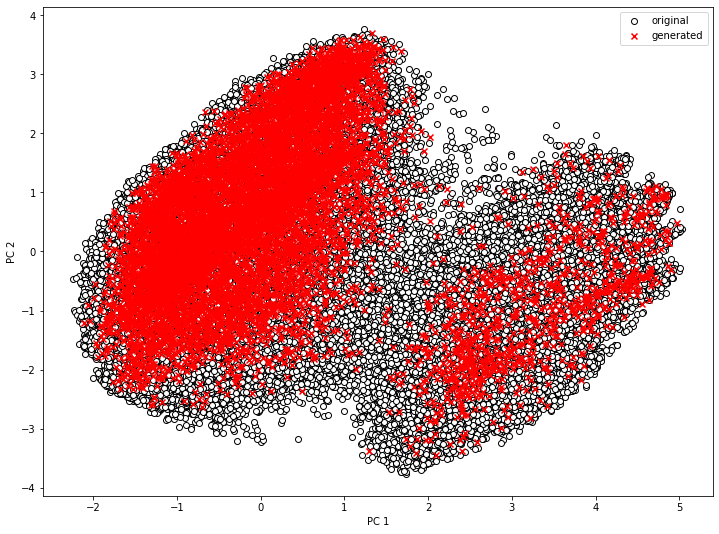

In [26]:
plt.figure(figsize=(12, 9))
plt.scatter(X[Vlen:, 0], X[Vlen:, 1], c='w', edgecolors='k', label='original')
plt.scatter(X[:Vlen, 0], X[:Vlen, 1], marker='x',c='r', label='generated')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend();

**Original and generated molecules are both in similar chemical space**

In order to compare the generated molecules to the original molecules used for RNN training, 24 common physiochemical features for the data were calculated. PCA was performed on these 24 generated features from the training molecules, and the first two pricipal components (PC1, PC2) were selected. The coordinates of the generated molecules were transformed accordingly. Figure above shows that there is overlap in the chemical subspace between these two sets of molecules.

In [27]:
props = {
    'MW': {
        'generated': [Descriptors.ExactMolWt(mol) for mol in valid_mols],
        'original': [Descriptors.ExactMolWt(mol) for mol in org_mols]        
    }
}

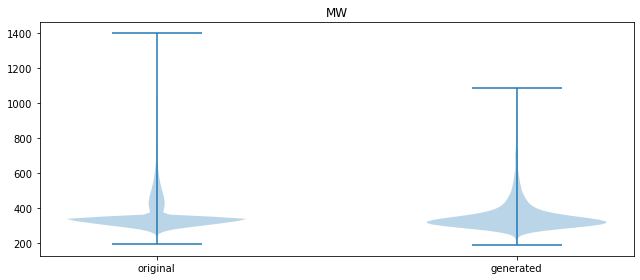

In [87]:
fig = plt.figure(figsize=(9, 4))

ax1 = fig.add_subplot(1, 1, 1)
ax1.violinplot([props['MW']['original'], props['MW']['generated']])
ax1.set_xticks(ticks=[1, 2])
ax1.set_xticklabels(labels=['original', 'generated'])
ax1.set_title('MW')


plt.tight_layout()

Violin plots for molecular weight (MW) distributions. Visual inspection reveals a close match of the generated and original molecules.

Molecular mass - Mass of a given molecule. Different molecules of the same compound may have different molecular masses because they contain different isotopes of an element.

Violin plots are similar to box plots, except that they also show the probability density of the data at different values, usually smoothed by a kernel density estimator.

# 5. Use transfer learning to fine-tune model

In [29]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole

from lstm_chem.utils.config import process_config
from lstm_chem.model import LSTMChem
from lstm_chem.finetuner import LSTMChemFinetuner
from lstm_chem.data_loader import DataLoader

In [30]:
config = process_config('experiments/base_experiment/LSTM_Chem/config.json')

modeler = LSTMChem(config, session='finetune')
finetune_dl = DataLoader(config, data_type='finetune')

finetuner = LSTMChemFinetuner(modeler, finetune_dl)
finetuner.finetune()

Loading model architecture from experiments/base_experiment/LSTM_Chem/model_arch.json ...


100%|██████████| 6/6 [00:00<00:00, 1891.03it/s]

Loading model checkpoint from experiments/base_experiment/LSTM_Chem/checkpoints/LSTM_Chem-baseline-model-full.hdf5 ...
Loaded the Model.
loading SMILES...
done.
tokenizing SMILES...
done.
Epoch 1/12


6/6 [==============================] - 3s 525ms/step - loss: 1.6315
Epoch 2/12
6/6 [==============================] - 3s 498ms/step - loss: 1.2192
Epoch 3/12
6/6 [==============================] - 3s 506ms/step - loss: 1.0080
Epoch 4/12
6/6 [==============================] - 3s 529ms/step - loss: 0.8961
Epoch 5/12
6/6 [==============================] - 3s 499ms/step - loss: 0.7339
Epoch 6/12
6/6 [==============================] - 3s 476ms/step - loss: 0.6847
Epoch 7/12
6/6 [==============================] - 3s 465ms/step - loss: 0.6361
Epoch 8/12
6/6 [==============================] - 3s 503ms/step - loss: 0.5591
Epoch 9/12
6/6 [==============================] - 3s 548ms/step - loss: 0.4829
Epoch 10/12
6/6 [==============================] - 3s 523ms/step - loss: 0.4048
Epoch 11/12
6/6 [==============================] - 3s 500ms/step - loss: 0.4530
Epoch 12/12
6/6 [==============================] - 3s 487ms/step - loss: 0.3754


In [53]:
# Generate 100 fine-tuned molecules
finetuned_smiles = finetuner.sample(num=100) 

In [64]:
finetuned_smiles

['CCC(C(=O)NC(C)C)C(=O)NC(C)C(=O)NC(C)C(=O)NC(Cc1ccccc1)C(C)OC',
 'Cc1cccc(CC(=O)O)c1CC1=COC(=O)C2OCC(OC(=O)NC(C(C)(C)C)C(Cc3ccccc3)NC1=O)C2N=C(N)N',
 'CCc1cccc(C)c1C(=O)NC(Cc1ccccc1)C(O)CC(Cc1ccccc1)NC(=O)OC',
 'CCC(CC)COC(=O)C(O)C(CCC(C)C)NC(=O)C(O)C(Cc1ccccc1)NC(=O)OC1COC2C(=O)CCC12',
 'Cc1ccccc1C(=O)NC(CSc1ccccc1)C(=O)NC(C)C(=O)NC(C)C(=O)NC(CO)C(=O)NC(C(=O)NC(C(C)C)N1CCCCC1C(N)C(C)(C)C)C(C)C',
 'CCC(NC(=O)C(O)COCc1ccccc1NC(Cc1ccccc1)NC(=O)OC)C(=O)NC(C)(C)C',
 'CC(C)CN(CC(O)C(Cc1ccccc1)NC(=O)C(NC(=O)C(NC(=O)OC1COC2OCCC12)C(C)(C)C)C(C)(C)C)S(=O)(=O)c1ccccc1',
 'Cc1cccc(C)c1-c1cnc2nc1N=CC=C2NC(C)(C)C',
 'CC(C)c1nc(C(C#N)CC(=O)NC(CCc2ccccc2)C(O)CC(CN(C)C)C(Cc2ccccc2)NC(=O)OCc2ccccc2)cs1',
 'Cc1cccc(C)c1CNC(C(=O)NC(O)C(CC(=O)O)NC(=O)OC=C1COC2OC3C1CCC3C2CS(=O)(=O)N1CCC=CC1c1ccccc1)C(C)C',
 'CC(C)CN(CC(CS(C)(=O)=O)C(Cc1ccccc1)NC(=O)OC1COC2OOCC12)C(=O)OCC(O)C(C)C',
 'COC(=O)NC(CC(CC(C)C)NC(=O)OCc1cccnc1)C(=O)NC1=CC=CC(C)=CC=C1O',
 'CC(=O)NC(C)CC(C(=O)NC(CC(=O)O)C(=O)NC(C(=O)NC(Cc1ccccc1)c1

In [65]:
# Save fine-tuned smiles
with open('./generations/finetuned_smiless.txt', 'w') as f:
    for item in finetuned_smiles:
        f.write("%s\n" % item)

### Compare generated molecules to the known protease inhibitors using Tanimoto similarity.

In [66]:
# Selected training molecules

with open('./datasets/protease_inhibitors_for_fine-tune.txt') as f:
    fsmiles = [l.rstrip() for l in f]
fmols = [Chem.MolFromSmiles(smi) for smi in fsmiles]

Fbvs = []
for mol in fmols:
    bv = AllChem.GetMACCSKeysFingerprint(mol)
    Fbvs.append(bv)

In [67]:
# Fine-tuned SMILES

Sbvs, smols = [], []
for smi in finetuned_smiles:
    mol = Chem.MolFromSmiles(smi)
    smols.append(mol)
    
    bv = AllChem.GetMACCSKeysFingerprint(mol)
    Sbvs.append(bv)

In [68]:
idxs = []
for Fbv in Fbvs:
    idx = np.argmax(DataStructs.BulkTanimotoSimilarity(Fbv, Sbvs))
    idxs.append(idx)
nsmols = [smols[idx] for idx in idxs]

In [69]:
idxs

[51, 73, 24, 8, 55, 36]

In [70]:
generated_finetuned_smiles = [finetuned_smiles[i] for i in idxs]
generated_finetuned_smiles

['CC(C)CN(CC1ON=CC(C)(Cc2ccccc2)C(=O)NC1Cc1ccccc1)NC(=O)OC1COC2C(=O)CCC12',
 'CC(C)(C)NC(=O)C1CC2CCCCC2CN1CC(O)C(Cc1ccccc1)NC(=O)C(Cc1ccccc1)NC(=O)C(C)(C)C',
 'Cc1cccc(C)c1OCC(=O)NC(CCc1ccc(O)nc1)NCC(=O)NC(c1ccccc1)C(C)C',
 'CC(C)c1nc(C(C#N)CC(=O)NC(CCc2ccccc2)C(O)CC(CN(C)C)C(Cc2ccccc2)NC(=O)OCc2ccccc2)cs1',
 'CC(C)CN(CC(O)C(Cc1ccccc1)NC(=O)OC1COC2OCCC12)S(=O)(=O)c1ccccc1',
 'COC(=O)NC(CN1CCCCC1C(=O)NC(C(=O)OCc1ccccc1)C(C)C)C(Cc1ccccc1)NC(=O)C(O)C(C)(C)C']

In [71]:
# save generated SMILES

with open('./generations/gen0_smiles.txt', 'w') as f:
    for item in generated_finetuned_smiles:
        f.write("%s\n" % item)

In [72]:
showmols = []
for i, j in zip(fmols, nsmols):
    showmols.append(i)
    showmols.append(j)

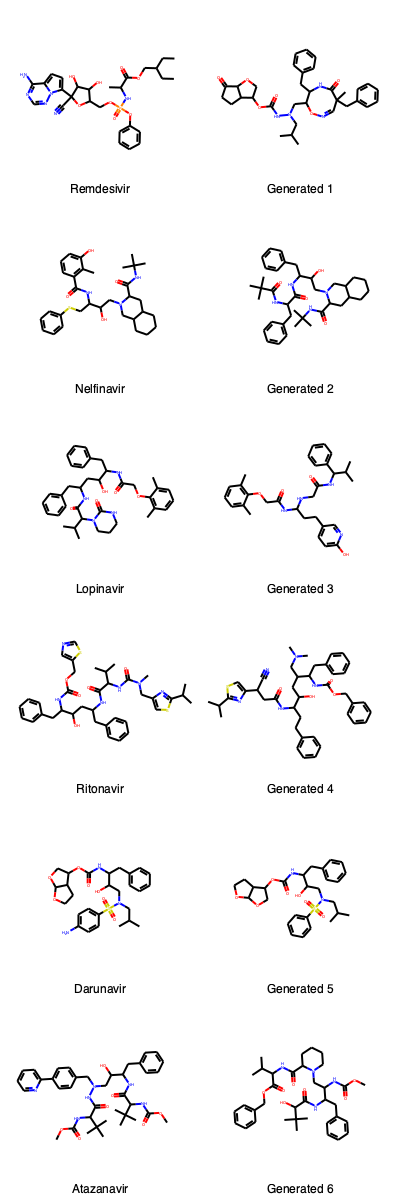

In [73]:
# Labels
labelList = ['Remdesivir', 'Generated 1',
             'Nelfinavir','Generated 2', 
             'Lopinavir','Generated 3',
             'Ritonavir','Generated 4',
             'Darunavir','Generated 5',
             'Atazanavir', 'Generated 6']

# Display molecules with labels
Draw.MolsToGridImage(showmols, molsPerRow=2, legends=[label for label in labelList])

Figure above shows the generated structures with highest Tanimoto similarity to the known protease inhibitors.

The six potential protease inhibitors of COVID-19 used to fine-tune the RNN model are shown on the left. The respective generated molecule with highest Tanimoto similarity (nearest neighbor) is shown on the right of every reference compound.

The Tanimoto coefficient T is the most popular similarity measure for comparing chemical structures represented by means of fingerprints.

# 6. Use PyRx to get binding scores of molecules with SARS-CoV-2 main protease

### Docking procedure with PyRx:
Download here: https://pyrx.sourceforge.io

PyRX ligand docking tutorial https://www.youtube.com/watch?v=2t12UlI6vuw

1. Open the structure of the protein and ligand complex (.cif crystallographic information file) https://www.rcsb.org/3d-view/6LU7
2. Select the ligand chain, delete the ligand, and save the file as a .pdb
3. Process generated SMILES and save it as .sdf file
4. Follow the video tutorial to get binding scores and save it as a csv file

## Process SMILES for PyRx Analysis

In [74]:
import pandas as pd
from rdkit import Chem, DataStructs
import random
import numpy as np
import rdkit.Chem.PropertyMol

In [75]:
gen0_table = pd.read_csv('./generations/gen0_smiles.txt',sep=',', header=None)
gen0 = list(gen0_table[0])
len(gen0)

6

In [76]:
def validate_mols(list_of_smiles):
    valid_mols = []
    for smi in list_of_smiles:
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            valid_mols.append(mol)
    return valid_mols

def convert_mols_to_smiles(list_of_mols):
    valid_smiles = [Chem.MolToSmiles(mol) for mol in list_of_mols]
    return valid_smiles

In [77]:
gen0_mols = validate_mols(gen0)
len(gen0_mols)

6

In [78]:
master_table = pd.read_csv('./generations/master_results_table.csv',sep=',')
master_table

,id,gen,smile,source,score


In [79]:
'''Certainly not opimized and not strictly necessary, but in the PyRx GUI
molecule names would sort oddly when in any numeric order, so ordering
molcules by a four letter code. This function iterates the four letter code.'''
def iterate_alpha(alpha_code):
    numbers = []
    for letter in alpha_code:
        number = ord(letter)
        numbers.append(number)
    
    if numbers[3]+1 > 90:
        if numbers[2]+1 > 90:
            if numbers[1]+1 > 90:
                if numbers[0]+1 > 90:
                    raise ValueError('Too long for alpha code')
                else:
                    numbers[3] = 65
                    numbers[2] = 65
                    numbers[1] = 65
                    numbers[0] = numbers[0] + 1
            else:
                numbers[3] = 65
                numbers[2] = 65
                numbers[1] = numbers[1] + 1
        else:
            numbers[3] = 65
            numbers[2] = numbers[2] + 1
    else:
        numbers[3] = numbers[3] + 1
    

    new_code = ""
    for number in numbers:
        new_code += chr(number)
    return new_code
iterate_alpha('AAAA')

'AAAB'

In [80]:
def append_to_tracking_table(master_table,mols_to_append, source, generation):
    # Assign IDs for tracking to each mol, and assign a pandas table entry for each
    mols_to_export = []
    rows_list = []
    
    master_table_gen = master_table[master_table['gen'] == generation]
    if master_table_gen.shape[0] == 0:
        id_code = 'AAAA'
    else:
        master_table_gen_ids = master_table_gen.sort_values('id', ascending=True)
        master_table_gen_max_id = master_table_gen_ids.tail(1)
        key = master_table_gen_max_id['id'].keys()[0]
        id_code = iterate_alpha(str(master_table_gen_max_id['id'][key]))
        
    
    for mol in mols_to_append:
        pm = Chem.PropertyMol.PropertyMol(mol)
        title = 'id' + str(id_code) + 'gen'+ str(generation)
        print(title)
        # Enables for tracking which molecule is which in PyRx GUI and PyRx results export
        pm.SetProp('Title', title)
        mols_to_export.append(pm)

        #And track in pandas
        mol_dict = {}
        mol_dict['id'] = id_code
        mol_dict['gen'] = generation
        smile = Chem.MolToSmiles(mol)
        assert type(smile) == type('string')
        mol_dict['smile'] = smile

        rows_list.append(mol_dict)
        id_code = iterate_alpha(id_code)
        
    df = pd.DataFrame(rows_list)
    return df, mols_to_export

In [81]:
new_mols_to_test = append_to_tracking_table(master_table,gen0_mols, 'generated', 0)
mols_for_pd = new_mols_to_test[0]
mols_for_export = new_mols_to_test[1]
master_table = master_table.append(mols_for_pd)
len(mols_for_export)

idAAAAgen0
idAAABgen0
idAAACgen0
idAAADgen0
idAAAEgen0
idAAAFgen0


6

In [82]:
master_table = master_table.reset_index(drop=True)
master_table.to_csv(r'./generations/master_results_table.csv', index=False)

In [83]:
# Add protease inhibitors into the table
hiv_smiles = pd.read_csv('./datasets/protease_inhibitors_for_fine-tune.txt',sep=',', header=None)
hiv_smiles = list(hiv_smiles[0])
hiv_mols = validate_mols(hiv_smiles)

master_table = pd.read_csv('./generations/master_results_table.csv',sep=',')
new_mols_to_test = append_to_tracking_table(master_table,hiv_mols, 'hiv', 0)
mols_for_pd = new_mols_to_test[0]
mols_for_export = mols_for_export + new_mols_to_test[1]

master_table = master_table.append(mols_for_pd)
master_table = master_table.reset_index(drop=True)
master_table.to_csv(r'./generations/master_results_table.csv', index=False)

idAAAGgen0
idAAAHgen0
idAAAIgen0
idAAAJgen0
idAAAKgen0
idAAALgen0


In [84]:
def write_gen_to_sdf(mols_for_export, generation, batch_size):
    if len(mols_for_export) > batch_size:
        batches = (len(mols_for_export) // 1000)+1
        for i in range(0,batches):
            batch_to_export = mols_for_export[i*batch_size:(i+1)*batch_size]
            w = Chem.SDWriter('./generations/gen' +str(generation) + '_batch_' + str(i+1) + '.sdf')
            for m in batch_to_export: w.write(m)
    else:
        w = Chem.SDWriter('./generations/gen' +str(generation) + '.sdf')
        for m in mols_for_export:
            w.write(m)
    
    return mols_for_export

In [85]:
write_gen_to_sdf(mols_for_export, 0, 2000)
print('ok')

ok


Generated molecules and protease inhibitors are saved in a sdf file. Next, go to PyRx to get binding scores of molecules with COVID-19 main protease (6LU7).

# 7. PyRx binding scores result

In [3]:
# Load Binding Scores Result 

score = pd.read_csv('./pyrx/binding-scores-final.csv')
score = score.iloc[:, [0,2]]
score = score.sort_values(by='Binding Affinity')
score = score.reset_index(drop=True)
score

,Ligand,Binding Affinity
0,Lopinavir,-6.9
1,Generated_3,-6.8
2,Generated_5,-6.3
3,Darunavir,-6.1
4,Generated_1,-6.0
5,Generated_6,-5.7
6,Generated_2,-5.5
7,Nelfinavir,-5.5
8,Atazanavir,-5.4
9,Remdesivir,-5.3


Lopinavir shows highest binding affinity of -6.9 kcal/mol with the COVID-19 main protease, followed closely by **Generated_3** molecule with binding affinity of **-6.8 kcal/mol** and Generated_5 molecule with binding affinity of -6.3 kcal/mol. 

The image below shows the structure of COVID-19 main protease (sky blue color) in complex with Generated_3 molecule (image taken from PyRx during the binding score analysis).

![AAAC-generated3.png](pyrx/AAAC-generated3.png)

COVID-19 Main Protease (6LU7) in complex with Generated_3 Molecule

# Future Work
- Select highest binding score candidates to re-train and produce molecules with higher binding affinity
- Increase generations
- Run in cloud GPU to save time